In [1]:
import os
os.chdir('..')
!pwd
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
df_medical = pd.read_csv('./data_small/insurance.csv')

# group memberships
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
print(A_t_medical_groups.sum(axis=0))

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64


In [3]:
A_t_medical_groups, A_t_medical_groups.shape

(      young  middle  old  underweight  healthyweight  overweight  obese  \
 0       1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 1       1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 2       1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 3       1.0     0.0  0.0          0.0            1.0         0.0    0.0   
 4       1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 ...     ...     ...  ...          ...            ...         ...    ...   
 1333    0.0     1.0  0.0          0.0            0.0         0.0    1.0   
 1334    1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 1335    1.0     0.0  0.0          0.0            0.0         0.0    1.0   
 1336    1.0     0.0  0.0          0.0            0.0         1.0    0.0   
 1337    0.0     0.0  1.0          0.0            0.0         1.0    0.0   
 
       smoker  non-smoker  male  female  always_on  
 0        1.0         0.0   0.0  

In [4]:
age_groups = ['young', 'middle', 'old']
bmi_groups = ['underweight', 'healthyweight', 'overweight', 'obese']
A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison

,young,middle,old,underweight,healthyweight,overweight,obese
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
1333,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1334,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1335,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1336,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [5]:
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh[['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']] = A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison
df_medical_mm_oh.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_young,age_middle,age_old,bmi_underweight,bmi_healthyweight,bmi_overweight,bmi_obese
0,0.021739,0.321227,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.479150,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.217391,0.458434,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.326087,0.181464,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
added_indicators = ['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
np.all(df_medical_mm_oh[added_indicators + ['smoker_yes', 'smoker_no', 'sex_male', 'sex_female']].to_numpy() == A_t_medical_groups.to_numpy()[:, :11]) # checks that A_t information is all included in the dataframe! no loss of group info to baseline so a fair comparison

True

In [7]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds
ds_ob = BuildGroupwise_diffseeds(df_medical_mm_oh, 'charges', A_t_medical_groups)
ds_ob.build_all_seeds()
ds_ob.build_df_res()
ds_ob.build_regret_curve()

100%|██████████| 1338/1338 [00:00<00:00, 6518.94it/s]


In [4]:
subgroups_list = [['young', 'middle', 'old'], ['underweight', 'healthyweight', 'overweight',
       'obese'], ['smoker', 'non-smoker'], ['male', 'female'], ['always_on']]

In [5]:
# from bilevel.Groupwise_seedruns import plot_subgroups, plot_regret_curve_with_std

# plot_subgroups(plot_ob, subgroups_list)

young 574


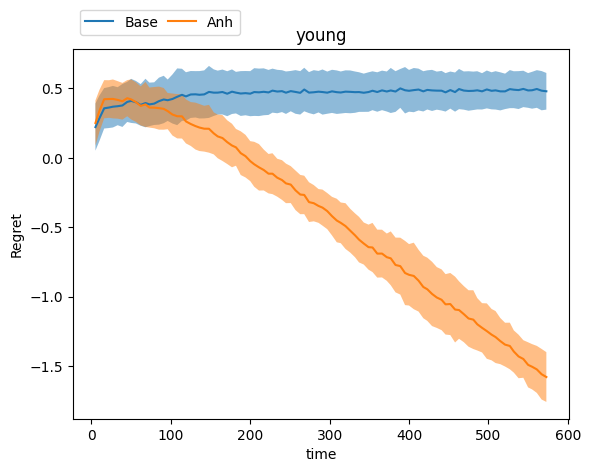

middle 408


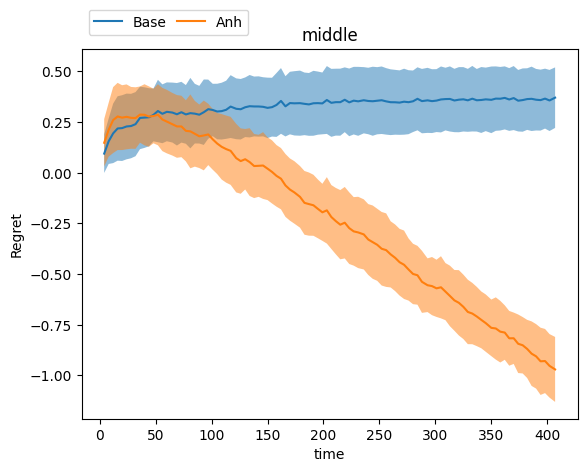

old 356


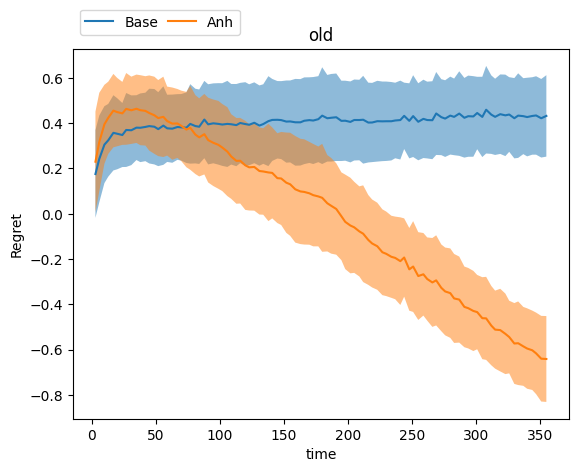

underweight 20


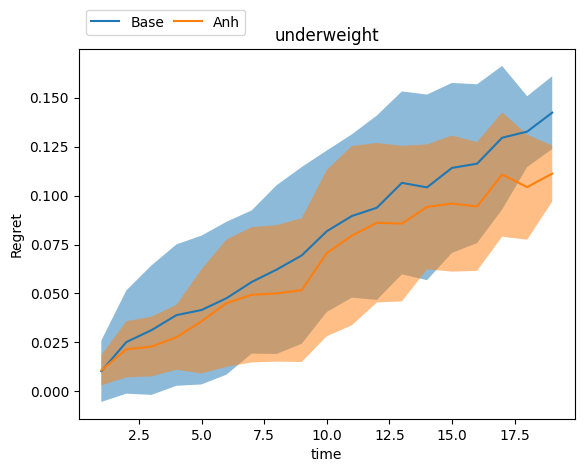

healthyweight 225


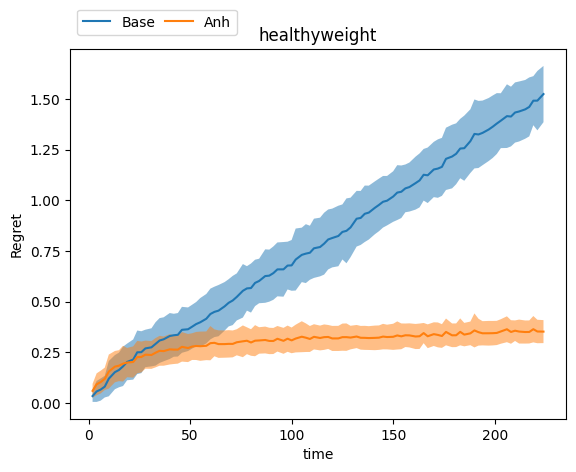

overweight 386


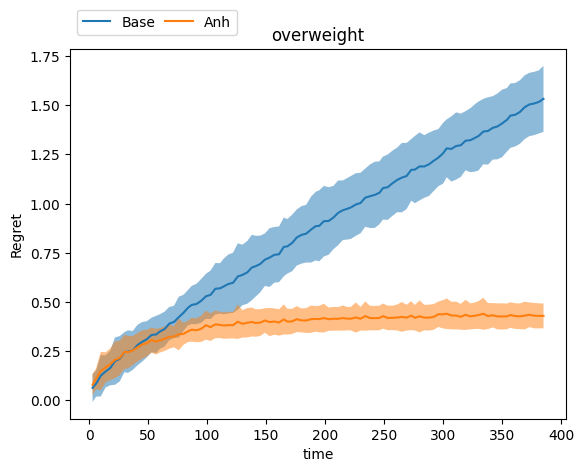

obese 707


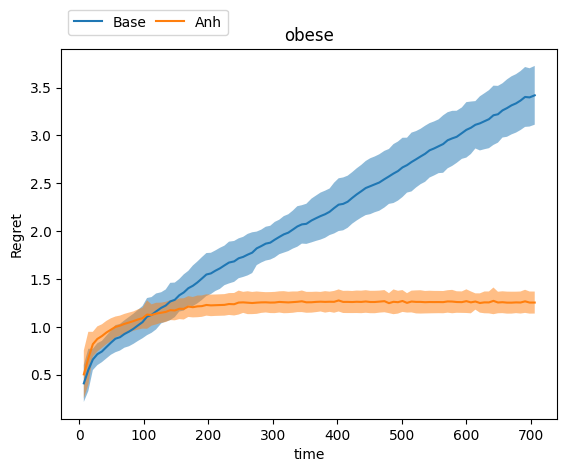

smoker 274


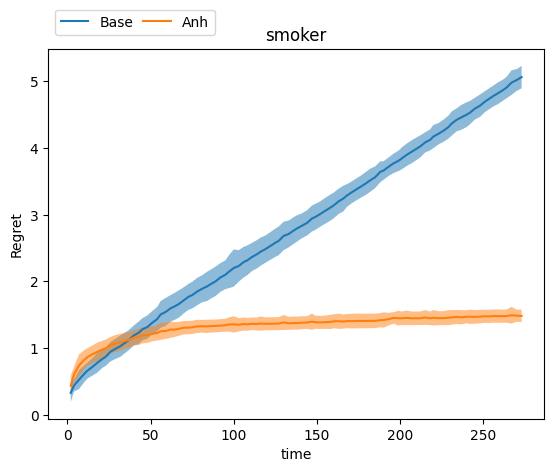

non-smoker 1064


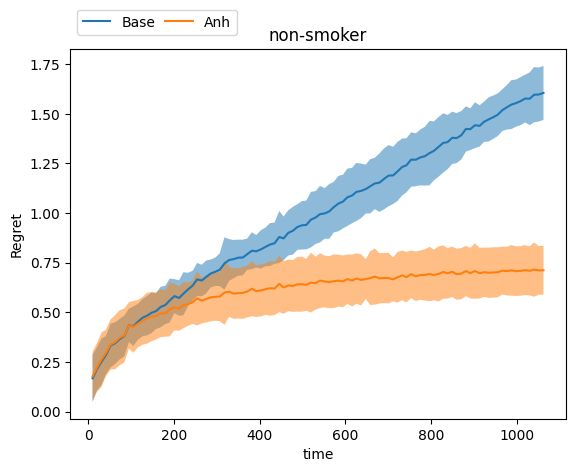

male 676


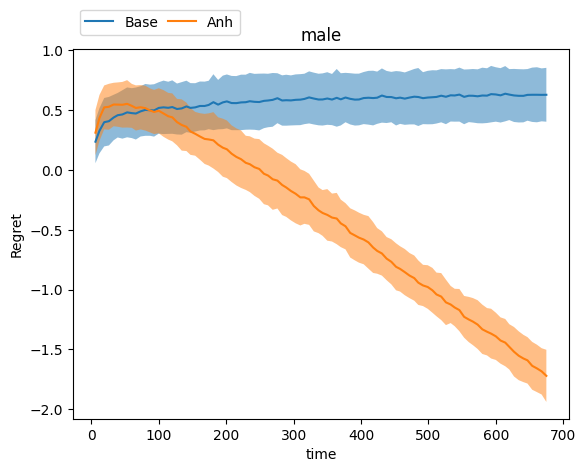

female 662


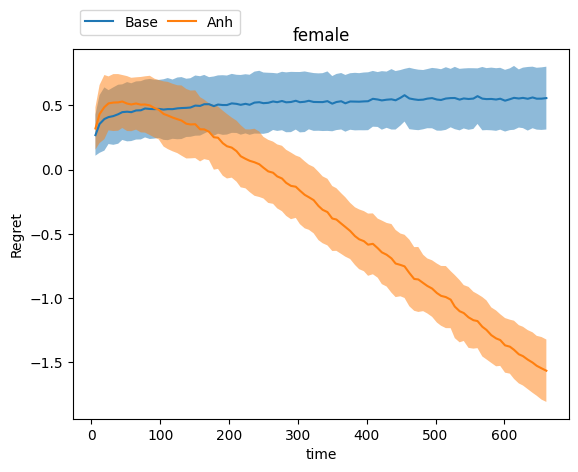

always_on 1338


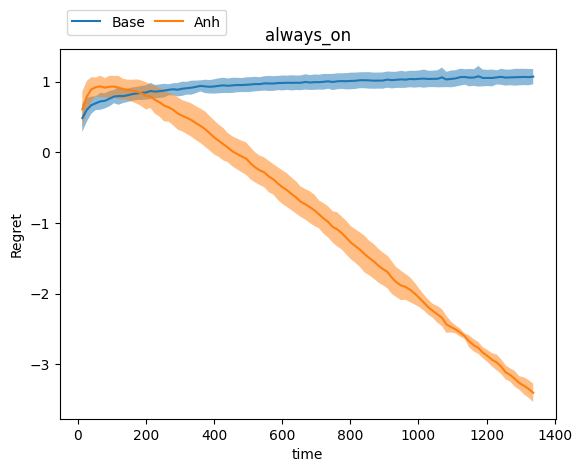

In [8]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
plot_regret_curve_with_std(ds_ob, 'medical_costs_plots_exploss')

In [17]:
save_ob('medical_gw_expcloss_fair.pkl', ds_ob)

In [10]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [9]:
performance_diff(ds_ob)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,5.967306,0.146098,4.164618,0.210651,1.802689,30.209422
middle,3.702279,0.176764,2.559506,0.221833,1.142773,30.866733
old,3.658443,0.197050,2.729327,0.203402,0.929116,25.396482
underweight,0.148706,0.016368,0.160650,0.032509,-0.011944,-8.031613
healthyweight,2.494085,0.128576,1.455495,0.060050,1.038590,41.642126
overweight,3.390774,0.155504,2.506525,0.086663,0.884248,26.078068
obese,7.294463,0.294631,5.330781,0.084179,1.963682,26.920175
smoker,6.510746,0.142940,3.237437,0.083683,3.273309,50.275484
non-smoker,6.817282,0.098125,6.216014,0.094506,0.601268,8.819760
male,6.866742,0.262068,4.800040,0.238718,2.066702,30.097277


In [11]:
performance_diff(ds_ob) # with the group indicators included to make a fair comparison to baseline

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
young,5.866828,0.144624,3.808552,0.188741,2.058276,35.083284
middle,3.706680,0.159263,2.365011,0.172215,1.341669,36.195969
old,3.562693,0.191081,2.489291,0.208740,1.073402,30.128949
underweight,0.168199,0.016382,0.137029,0.017225,0.031170,18.531808
healthyweight,2.527836,0.146259,1.356030,0.059749,1.171806,46.356099
overweight,3.369475,0.176528,2.266466,0.066592,1.103009,32.735327
obese,7.070692,0.324209,4.903330,0.121507,2.167362,30.652754
smoker,5.964842,0.177671,2.384703,0.098569,3.580139,60.020684
non-smoker,7.171359,0.143396,6.278152,0.128886,0.893208,12.455208
male,6.710165,0.240197,4.359355,0.232062,2.350810,35.033565


In [18]:
from bilevel.Groupwise_seedruns import get_end_regret_gw_df

df_regend = get_end_regret_gw_df(ds_ob)

In [19]:
df_regend

,group_name,group_size,mean_regend_Base,std_regend_Base,mean_regend_Anh,std_regend_Anh
0,young,574,0.478884,0.132048,-1.579392,0.179257
1,middle,408,0.370734,0.149399,-0.970935,0.160392
2,old,356,0.431891,0.179852,-0.641510,0.189596
3,underweight,20,0.142358,0.018594,0.111188,0.014274
4,healthyweight,225,1.523728,0.138809,0.351922,0.056745
5,overweight,386,1.532813,0.167311,0.429805,0.063129
6,obese,707,3.419838,0.307273,1.252476,0.114990
7,smoker,274,5.064600,0.168286,1.484461,0.093652
8,non-smoker,1064,1.604927,0.135972,0.711720,0.122260
9,male,676,0.628809,0.225236,-1.722001,0.218088


In [21]:
df_regend.to_csv('df_regend_medicalcosts.csv')

In [20]:
df_regend['mean_regend_Base'] - df_regend['mean_regend_Anh']

0     2.058276
1     1.341669
2     1.073402
3     0.031170
4     1.171806
5     1.103009
6     2.167362
7     3.580139
8     0.893208
9     2.350810
10    2.122537
11    4.473347
dtype: float64